<a href="https://colab.research.google.com/github/Aleo0/AnimeRecommenderSystem/blob/main/Anime_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy


In [ ]:
# Veri setlerini yükle
anime_df = pd.read_csv("anime.csv")
rating_df = pd.read_csv("rating.csv")

In [ ]:
# anime_df'nin boyutlarını (satır, sütun) yazdır
print("anime_df boyutları:", anime_df.shape)

# rating_df'nin boyutlarını (satır, sütun) yazdır
print("rating_df boyutları:", rating_df.shape)

anime_df boyutları: (12294, 7)
rating_df boyutları: (7813737, 3)


In [ ]:
# İlk 5 satırı görüntüle
print("Anime Verisi:")
print(anime_df.head())
print("\nKullanıcı Puanlama Verisi:")
print(rating_df.head())

Anime Verisi:
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  

Kullanıcı Puanlama Verisi:
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1       

In [ ]:
# yalnızca derecelendirilmiş animeleri dikkate almak istediğimiz için -1 değerlerini kaldırıyorum
rating_df = rating_df[rating_df['rating'] != -1]

In [ ]:
# her sütundaki eksik değerlerin sayısını bize gösterecek
print("Anime Verisi Eksik Değerler:\n", anime_df.isnull().sum())
print("\nKullanıcı Puanlama Verisi Eksik Değerler:\n", rating_df.isnull().sum())

Anime Verisi Eksik Değerler:
 anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Kullanıcı Puanlama Verisi Eksik Değerler:
 user_id     0
anime_id    0
rating      0
dtype: int64


In [ ]:
# anime_df'deki 'rating' sütununda eksik değerleri olan satırları siliyoruz
anime_df.dropna(subset=['rating'], inplace=True)

# Güncellenmiş anime_df'deki eksik değerleri kontrol ediyoruz
print("Anime Verisi Eksik Değerler (Silme Sonrası):\n", anime_df.isnull().sum())

Anime Verisi Eksik Değerler (Silme Sonrası):
 anime_id     0
name         0
genre       47
type         0
episodes     0
rating       0
members      0
dtype: int64


In [ ]:
# Veri setine kıyasla küçük miktarlarda olduğu için eksik değer olan satırları siliyoruz.

# genre ve type sütunlarında eksik değer olan satırları sil
anime_df.dropna(subset=['genre', 'type'], inplace=True)

# Silme işleminden sonra eksik değerleri tekrar kontrol et
print("Anime Verisi Eksik Değerler (Silme Sonrası):\n", anime_df.isnull().sum())

Anime Verisi Eksik Değerler (Silme Sonrası):
 anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


In [ ]:
# her sütunun veri tipini gösterir
print("Anime Verisi Bilgileri:")
anime_df.info()
print("\nKullanıcı Puanlama Verisi Bilgileri:")
rating_df.info()

Anime Verisi Bilgileri:
<class 'pandas.core.frame.DataFrame'>
Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB

Kullanıcı Puanlama Verisi Bilgileri:
<class 'pandas.core.frame.DataFrame'>
Index: 6337241 entries, 47 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 193.4 MB


In [ ]:
# anime_df ve rating_df'deki anime_id değerlerini karşılaştırıyoruz. rating_df'de olup anime_df'de olmayan anime_id'ler var mı kontrol edelim.
print("Rating'de olup Anime'de olmayan anime_id sayısı:", len(set(rating_df["anime_id"]) - set(anime_df["anime_id"])))

Rating'de olup Anime'de olmayan anime_id sayısı: 35


In [ ]:
# Farklı olan anime_id'yi bulalım
farkli_anime_id = list(set(rating_df["anime_id"]) - set(anime_df["anime_id"]))[0]
print("Farklı anime_id:", farkli_anime_id)

Farklı anime_id: 29957


In [ ]:
# Bu anime_id'ye sahip satırları rating_df'den silelim
rating_df = rating_df[rating_df['anime_id'] != farkli_anime_id]

In [ ]:
# Tekrar kontrol edelim
print("Rating'de olup Anime'de olmayan anime_id sayısı:", len(set(rating_df["anime_id"]) - set(anime_df["anime_id"])))

Rating'de olup Anime'de olmayan anime_id sayısı: 34


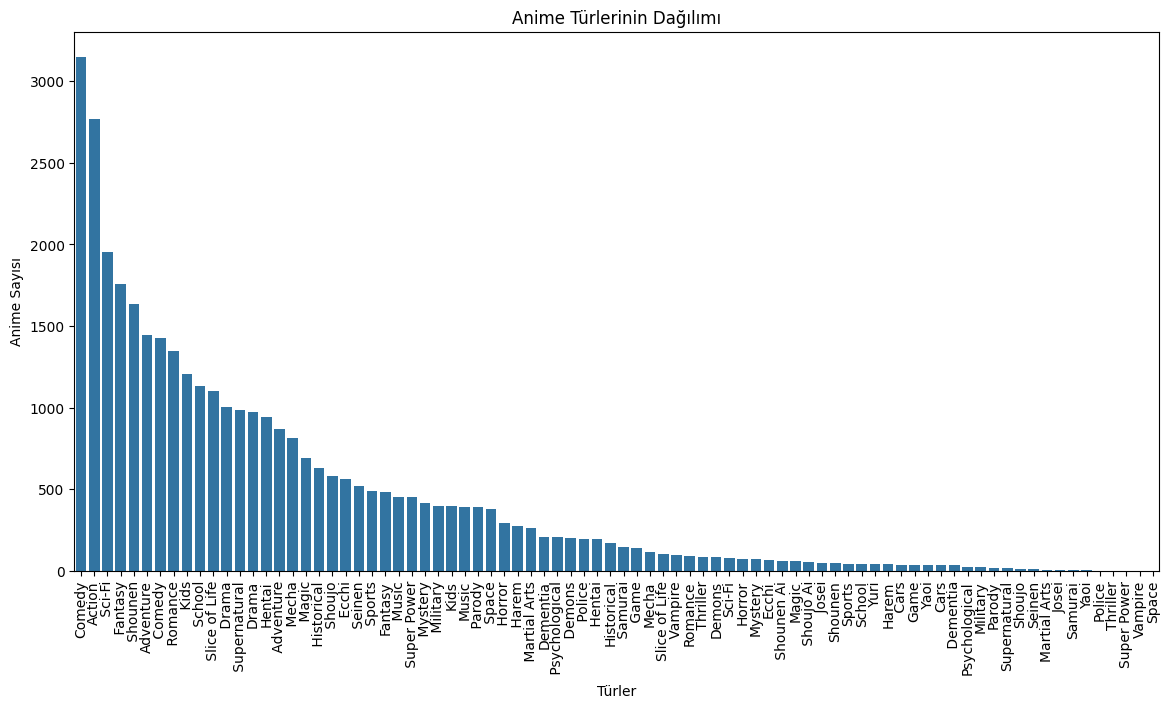

In [ ]:
# Tür Dağılımı: En popüler anime türleri neler? Bar grafiği

# Önce her animenin türlerini içeren bir liste oluşturuyoruz
all_genres = []
for genres in anime_df['genre'].dropna():
    all_genres.extend(genres.split(','))

# Şimdi bu listeden türlerin sayısını hesaplayıp bir DataFrame'e dönüştürelim
genre_counts = pd.Series(all_genres).value_counts()

# Bar grafiği çiziyoruz
plt.figure(figsize=(14, 7))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=90)
plt.title("Anime Türlerinin Dağılımı")
plt.xlabel("Türler")
plt.ylabel("Anime Sayısı")
plt.show()

# Yorum:
# Bu grafiği çalıştırdıktan sonra, en popüler anime türlerini göreceğiz.
# Hangi türlerin daha fazla anime içerdiğini ve aralarındaki sayısal farkları yorumlayabiliriz.

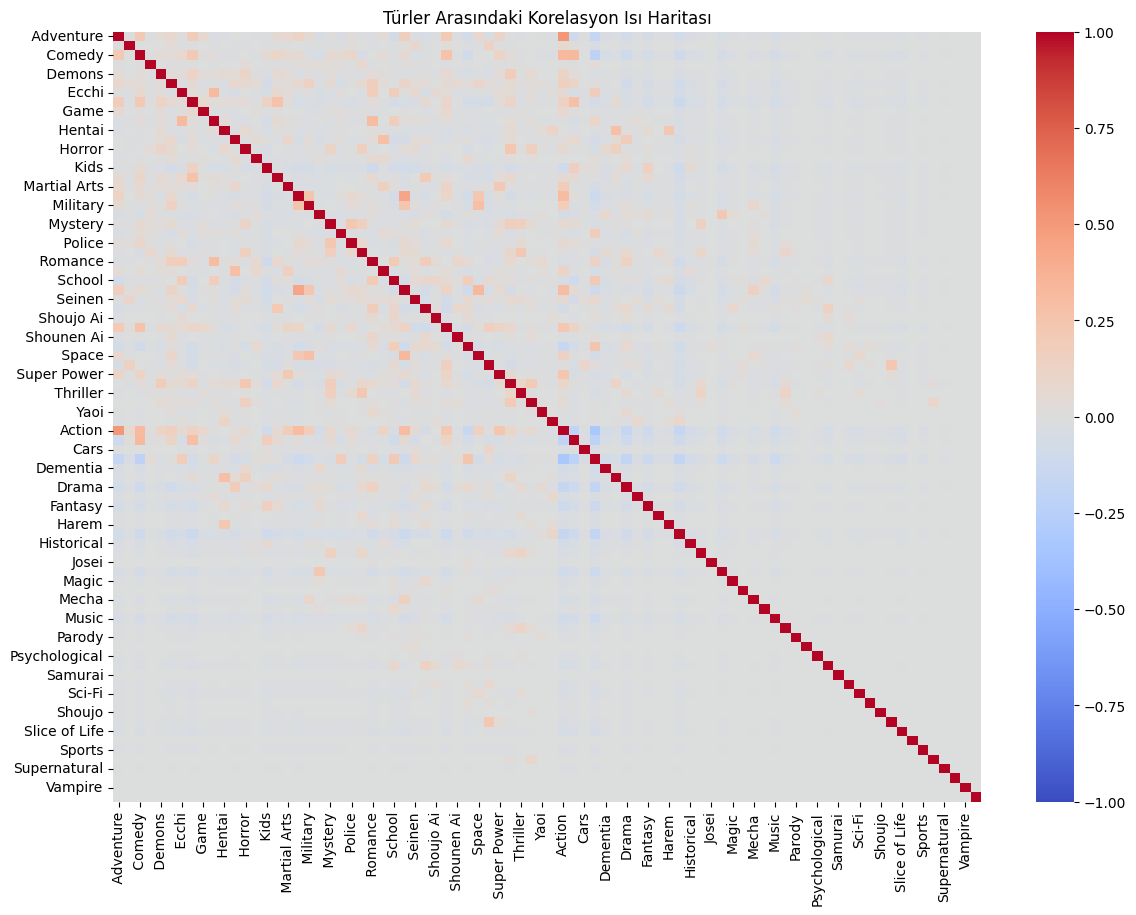

In [ ]:
# Türlerin birlikte görünme matrisini oluşturma
from sklearn.preprocessing import MultiLabelBinarizer

# 'genre' sütunundaki türleri virgülle ayırarak listeye dönüştür
anime_df['genre_list'] = anime_df['genre'].str.split(',')

# MultiLabelBinarizer kullanarak türleri ikili (binary) formata dönüştür
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(anime_df['genre_list'].dropna())
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

# Türler arasındaki korelasyonu hesapla
genre_correlation = genre_df.corr()

# Isı haritasını çiz
plt.figure(figsize=(14, 10))
sns.heatmap(genre_correlation, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Türler Arasındaki Korelasyon Isı Haritası")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

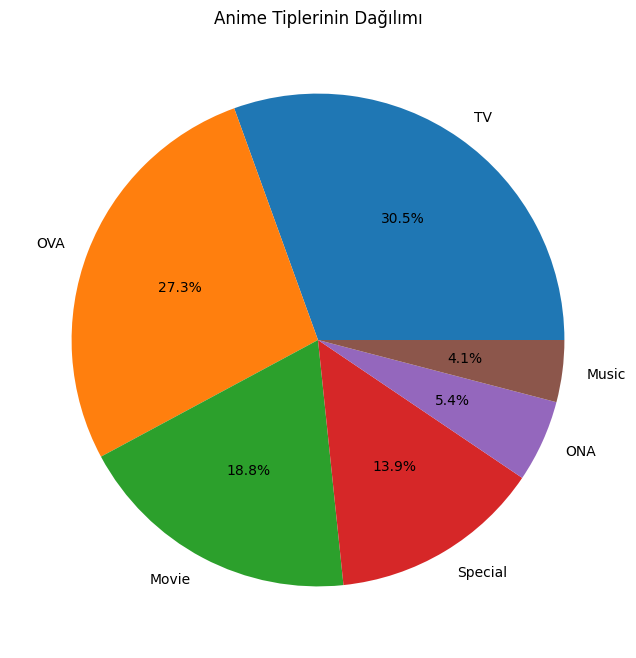

In [ ]:
# Tip Dağılımı: Animeler arasında "Movie", "TV", "OVA" gibi türlerin dağılımı nasıl?
# pasta grafiği


plt.figure(figsize=(8, 8))
type_counts = anime_df["type"].value_counts()
plt.pie(type_counts.values, labels=type_counts.index, autopct="%1.1f%%")
plt.title("Anime Tiplerinin Dağılımı")
plt.show()

# Yorum: Bu pasta grafiği, farklı anime tiplerinin (Movie, TV, OVA, vb.) yüzdesel dağılımını gösterecek.
# Hangi tipin daha yaygın olduğunu görebiliriz.

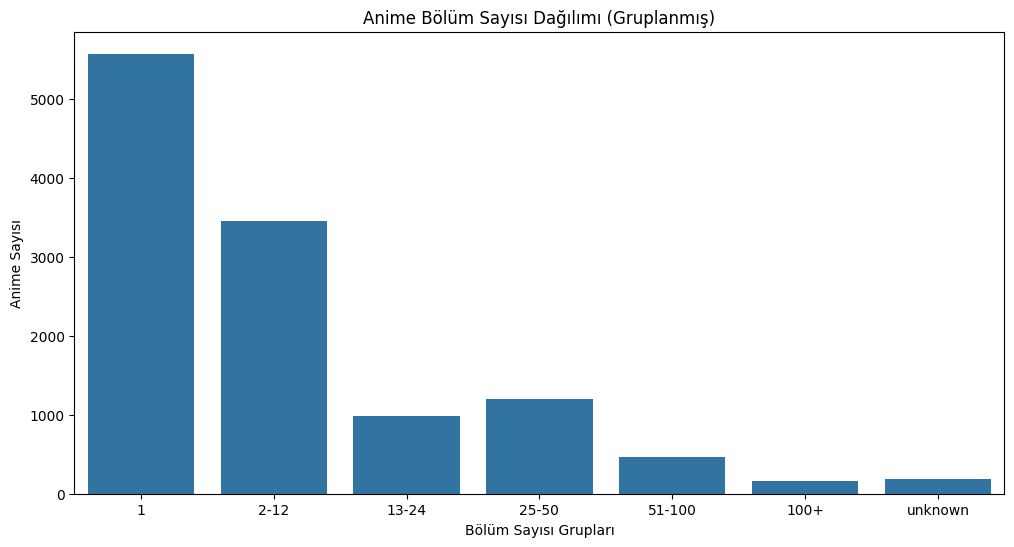

In [ ]:
# Bölüm Sayısı Dağılımı: Bölüm sayılarının dağılımını inceleyebiliriz.
# Histogram grafiği

def group_episodes(episodes):
    try:
        episodes = int(episodes)  # episodes değerini integer'a dönüştürmeye çalış
    except ValueError:
        return "unknown"  # Dönüştürme başarısız olursa "unknown"" döndür

    if episodes == 1:
        return "1"
    elif episodes <= 12:
        return "2-12"
    elif episodes <= 24:
        return "13-24"
    elif episodes <= 50:
        return "25-50"
    elif episodes <= 100:
        return "51-100"
    else:
        return "100+"

anime_df["episodes_group"] = anime_df["episodes"].apply(group_episodes)

plt.figure(figsize=(12, 6))
sns.countplot(x="episodes_group", data=anime_df, order=["1", "2-12", "13-24", "25-50", "51-100", "100+", "unknown"])
plt.title("Anime Bölüm Sayısı Dağılımı (Gruplanmış)")
plt.xlabel("Bölüm Sayısı Grupları")
plt.ylabel("Anime Sayısı")
plt.show()


# Yorum: Bu histogram, animelerin bölüm sayılarının nasıl dağıldığını gösterecek.

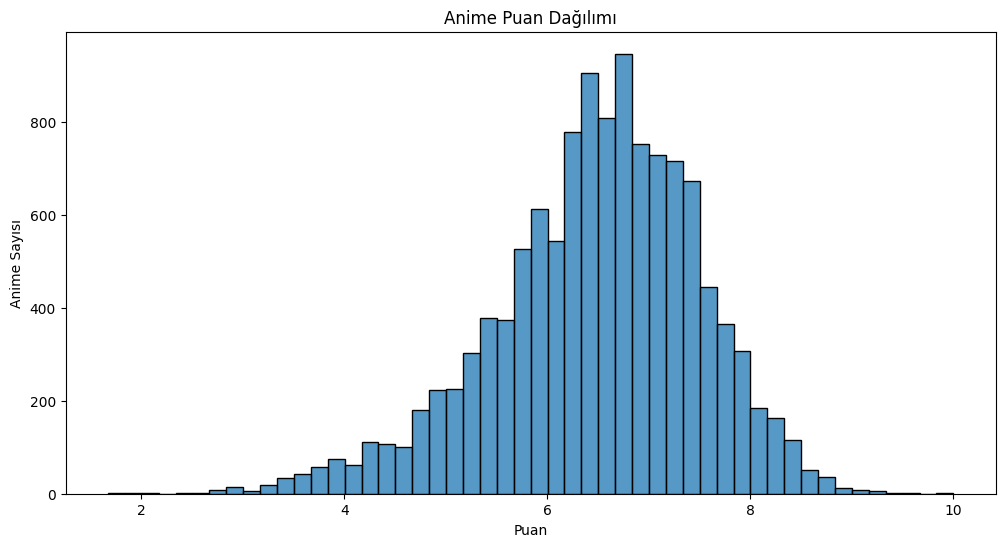

In [ ]:
# Histogram grafiği ile animelerin puan dağılımını inceliyoruz.

plt.figure(figsize=(12, 6))
sns.histplot(anime_df["rating"], bins=50)
plt.title("Anime Puan Dağılımı")
plt.xlabel("Puan")
plt.ylabel("Anime Sayısı")
plt.show()



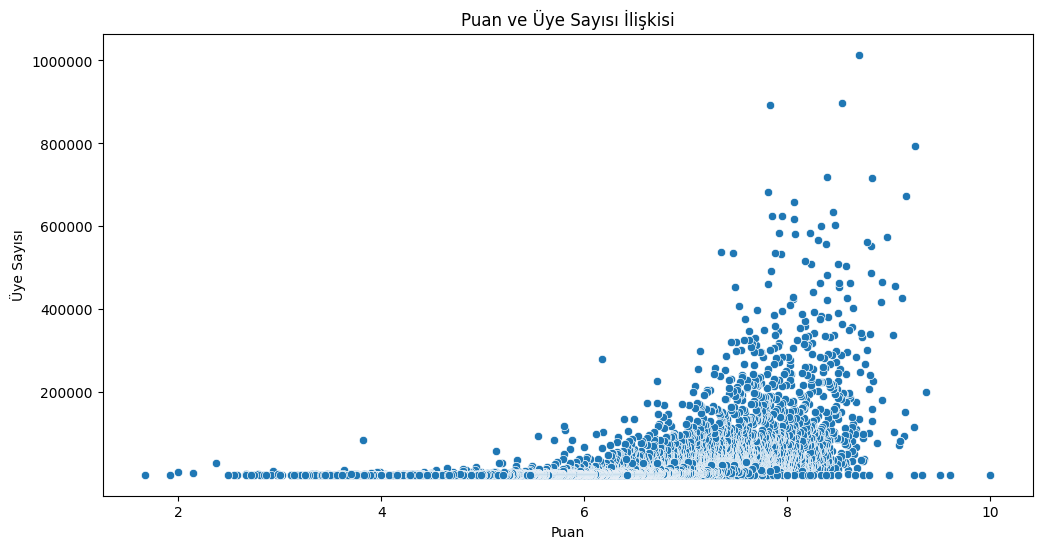

In [ ]:
# Puan ve Üye Sayısı İlişkisi: Puan ile üye sayısı arasında bir ilişki var mı? Bunu bir scatter plot ile inceleyelim.

plt.figure(figsize=(12, 6))
sns.scatterplot(x="rating", y="members", data=anime_df)
plt.title("Puan ve Üye Sayısı İlişkisi")
plt.xlabel("Puan")
plt.ylabel("Üye Sayısı")

# Dikey ekseni biçimlendirme
plt.ticklabel_format(style='plain', axis='y')  # Bilimsel gösterimi kapatır
plt.yticks([200000, 400000, 600000, 800000, 1000000]) # Belirli aralıkları gösterir.

plt.show()

In [ ]:
# Kullanıcı Başına Ortalama Puan: Her kullanıcının verdiği ortalama puan nedir? Bunun dağılımını bir histogram ile inceleyelim.

plt.figure(figsize=(12, 6))
user_avg_ratings = rating_df.groupby("user_id")["rating"].mean()
sns.histplot(user_avg_ratings, bins=30)
plt.title("Kullanıcı Başına Ortalama Puan Dağılımı")
plt.xlabel("Ortalama Puan")
plt.ylabel("Kullanıcı Sayısı")
plt.show()

# Yorum:
# Bu histogram, her kullanıcının verdiği ortalama puanların dağılımını gösterecek.
# Kullanıcıların genel olarak yüksek mi yoksa düşük mü puan verme eğiliminde olduklarını görebiliriz.

In [ ]:
# Anime Başına Ortalama Puan: Her animenin aldığı ortalama puan nedir?

plt.figure(figsize=(12, 6))
anime_avg_ratings = rating_df.groupby("anime_id")["rating"].mean()
sns.histplot(anime_avg_ratings, bins=30)
plt.title("Anime Başına Ortalama Puan Dağılımı")
plt.xlabel("Ortalama Puan")
plt.ylabel("Anime Sayısı")
plt.show()

In [ ]:
#En Çok Puan Veren Kullanıcılar: En çok anime puanlayan kullanıcılar kimler?

top_users = rating_df["user_id"].value_counts().head(10)
print("En Çok Puan Veren 10 Kullanıcı:\n", top_users)

# Yorum: En çok anime puanlayan ilk 10 kullanıcının ID'lerini ve kaçar anime puanladıklarını görüyoruz.

In [ ]:
# En Çok Puan Alan Animeler: En çok puan alan animeler hangileri?

top_rated_animes = rating_df.groupby("anime_id")["rating"].mean().sort_values(ascending=False).head(10)
top_rated_animes_names = anime_df[anime_df["anime_id"].isin(top_rated_animes.index)][["anime_id", "name"]]
print("En Çok Puan Alan 10 Anime:\n", pd.merge(top_rated_animes_names, top_rated_animes, on="anime_id"))

# Yorum: En yüksek ortalama puana sahip ilk 10 anime, isimleri ve ortalama puanları

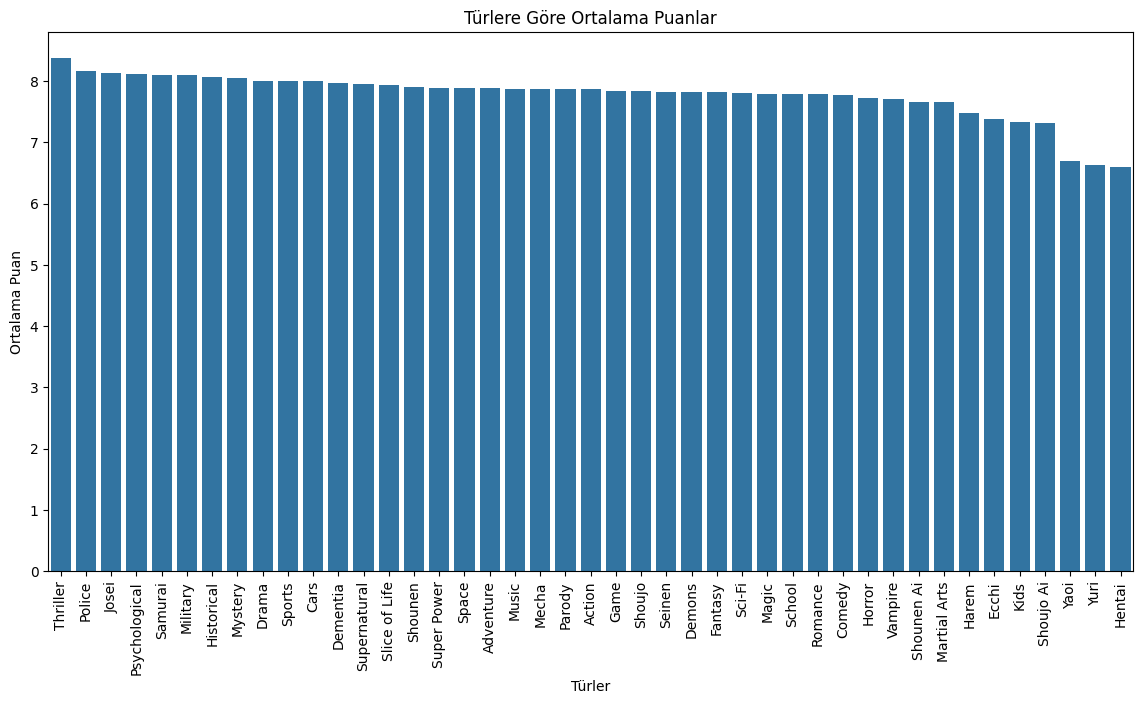

In [ ]:
# Türlere Göre Ortalama Puanlar: Farklı türlerdeki animelerin ortalama puanları nasıl değişiyor? Bar grafiği ile görelim.

# anime_df'de her anime için türleri bir listeye çevirelim
anime_df["genre_list"] = anime_df["genre"].str.split(", ")

# rating_df ile anime_df'i anime_id üzerinden birleştirelim
merged_df = pd.merge(rating_df, anime_df, on="anime_id")

# Her tür için ortalama puanı hesaplayalım
genre_ratings = merged_df.explode("genre_list").groupby("genre_list")["rating_x"].mean().sort_values(ascending=False)

# Bar grafiği çizelim
plt.figure(figsize=(14, 7))
sns.barplot(x=genre_ratings.index, y=genre_ratings.values)
plt.xticks(rotation=90)
plt.title("Türlere Göre Ortalama Puanlar")
plt.xlabel("Türler")
plt.ylabel("Ortalama Puan")
plt.show()

# Yorum: Bu grafik, her anime türünün ortalama puanını gösteriyor. Hangi türlerin daha yüksek puanlar aldığını görebiliriz.

<ipython-input-26-702c8fd6f5ab>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  episode_group_ratings = merged_df.groupby("episode_group")["rating_x"].mean()


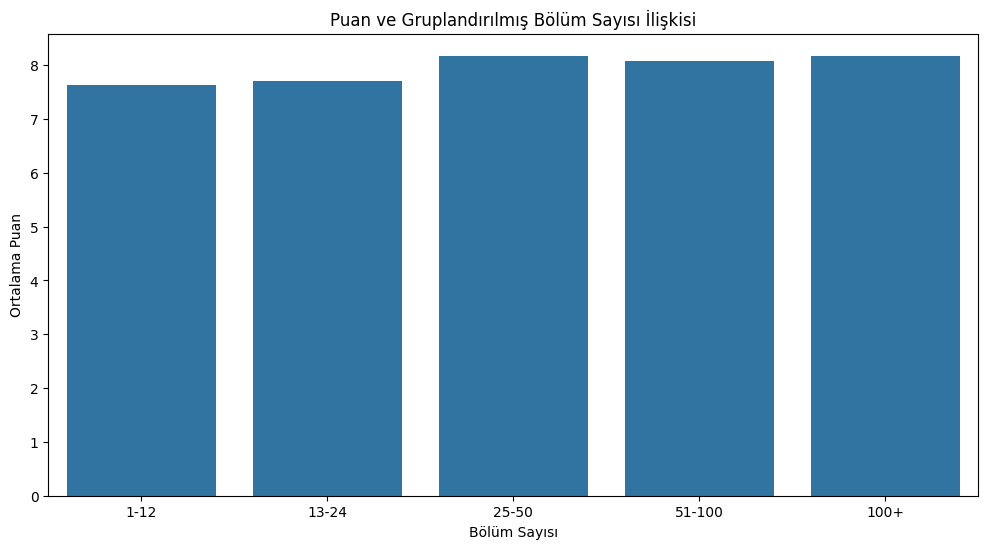

In [ ]:
# Puan ve Bölüm Sayısı İlişkisi: Puan ile bölüm sayısı arasında bir ilişki var mı?

plt.figure(figsize=(12, 6))

# Bölüm sayıları için aralıkları belirliyoruz
bins = [0, 12, 24, 50, 100, np.inf]
labels = ["1-12", "13-24", "25-50", "51-100", "100+"]

# 'episodes' sütununu bu aralıklara göre gruplandırıyoruz
merged_df["episodes"] = pd.to_numeric(merged_df["episodes"], errors='coerce')
merged_df["episode_group"] = pd.cut(merged_df["episodes"], bins=bins, labels=labels, right=False)

# Gruplara göre ortalama puanları hesaplıyoruz
episode_group_ratings = merged_df.groupby("episode_group")["rating_x"].mean()

# Bar grafiği çiziyoruz
sns.barplot(x=episode_group_ratings.index, y=episode_group_ratings.values)
plt.title("Puan ve Gruplandırılmış Bölüm Sayısı İlişkisi")
plt.xlabel("Bölüm Sayısı")
plt.ylabel("Ortalama Puan")
plt.show()

# Yorum: Bu grafik, her anime türünün ortalama puanını gösterecek. Hangi türlerin daha yüksek puanlar aldığını görebiliriz.

In [ ]:
# En Popüler Animeler: Hem yüksek puan almış hem de çok kişi tarafından puanlanmış animeler hangileri?

anime_popularity = rating_df.groupby("anime_id")["rating"].agg(["count", "mean"])
anime_popularity = anime_popularity[anime_popularity["count"] > 1000] # 1000'den fazla oy alanları filtrele
top_popular_animes = anime_popularity.sort_values(by="mean", ascending=False).head(10)
top_popular_animes_names = anime_df[anime_df["anime_id"].isin(top_popular_animes.index)][["anime_id", "name"]]
print("En Popüler 10 Anime (1000'den fazla oy alanlar arasında):\n", pd.merge(top_popular_animes_names, top_popular_animes, on="anime_id"))

# Yorum: Bu çıktı, hem 1000'den fazla oy almış hem de en yüksek ortalama puana sahip ilk 10 animeyi gösterecek.
# Bu animeler, hem popüler hem de yüksek puanlı olarak kabul edilebilir.

En Popüler 10 Anime (1000'den fazla oy alanlar arasında):
    anime_id                                               name  count  \
0     32281                                     Kimi no Na wa.   1961   
1      5114                   Fullmetal Alchemist: Brotherhood  21494   
2     28977                                           Gintama°   1188   
3      9253                                        Steins;Gate  17151   
4      9969                                      Gintama&#039;   3115   
5     32935  Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...   1038   
6     11061                             Hunter x Hunter (2011)   7477   
7     15335  Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...   2147   
8     15417                           Gintama&#039;: Enchousen   2126   
9       918                                            Gintama   4264   

       mean  
0  9.426313  
1  9.322741  
2  9.449495  
3  9.261326  
4  9.272552  
5  9.171484  
6  9.234586  
7  9.191430  
8  9.202258

In [ ]:
# Reader nesnesi oluştur (1-10 arası puanlama)
reader = Reader(rating_scale=(1, 10))

# Veriyi Surprise formatına dönüştür
data = Dataset.load_from_df(rating_df[['user_id', 'anime_id', 'rating']], reader)

# Veriyi eğitim ve test olarak ayır
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# SVD modelini oluştur ve eğit
model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
model.fit(trainset)

# Test seti üzerinde performansı değerlendir
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

def get_anime_recommendations(user_id, n_recommendations=5):
    # Kullanıcının izlemediği animeleri bul
    watched_animes = set(rating_df[rating_df['user_id'] == user_id]['anime_id'])
    all_animes = set(anime_df['anime_id'])
    unwatched_animes = list(all_animes - watched_animes)

    # Her izlenmemiş anime için tahmin yap
    predictions = []
    for anime_id in unwatched_animes:
        pred = model.predict(user_id, anime_id)
        predictions.append((anime_id, pred.est))

    # En yüksek puanlı N animeyi seç
    top_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    # Sonuçları anime isimleriyle birleştir
    recommendations = []
    for anime_id, pred_rating in top_predictions:
        anime_info = anime_df[anime_df['anime_id'] == anime_id].iloc[0]
        recommendations.append({
            'name': anime_info['name'],
            'predicted_rating': round(pred_rating, 2),
            'genre': anime_info['genre'],
            'type': anime_info['type']
        })

    return recommendations

In [ ]:
user_id = 73516
user_ratings = rating_df[rating_df['user_id'] == user_id]

print(f"Model Performansı:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

print(f"\nKullanıcı {user_id}:")
print(f"Şimdiye kadar verdiği puanların ortalaması: {user_ratings['rating'].mean():.2f}")
print("\nÖnerilen Animeler:")
recommendations = get_anime_recommendations(user_id, n_recommendations=5)
for i, rec in enumerate(recommendations, 1):
   print(f"\n{i}. {rec['name']}")
   print(f"   Tahmini Beğeni: {rec['predicted_rating']}/10")
   print(f"   Tür: {rec['genre']}")
   print(f"   Tip: {rec['type']}")